In [1]:
from ROOT import TH1F, TCanvas, TF1, gStyle

Welcome to JupyROOT 6.18/04


In [2]:
import os
import re

In [3]:
regex= re.compile(r'\d+')

In [4]:
import numpy as np
from sklearn.metrics import mean_squared_error

In [23]:
from functools import partial

In [5]:
saved_models = '/storage/yw18581/src/leaf_reco/saved_models/trained_6positions/'

In [24]:
root_path = partial(os.path.join, saved_models)

In [50]:
def get_params(file):
    epoch = int(regex.findall(os.path.split(file)[1].split('_')[3])[0])
    coef = int(regex.findall(os.path.split(file)[1].split('_')[4])[1])
    return epoch, coef

In [6]:
model_names = os.listdir(saved_models)

In [7]:
model_names

['Trained_rUNet_pytorch_6positions_dataset_5epochs_0.75coeff_mask.pkl',
 'Trained_rUNet_pytorch_6positions_dataset_10epochs_0.75coeff_mask.pkl',
 'Trained_rUNet_pytorch_6positions_dataset_15epochs_0.75coeff_mask.pkl',
 'Trained_rUNet_pytorch_6positions_dataset_20epochs_0.75coeff_mask.pkl',
 'Trained_rUNet_pytorch_6positions_dataset_25epochs_0.75coeff_mask.pkl',
 'Trained_rUNet_pytorch_6positions_dataset_30epochs_0.75coeff_mask.pkl',
 'Trained_rUNet_pytorch_6positions_dataset_35epochs_0.75coeff_mask.pkl',
 'Trained_rUNet_pytorch_6positions_dataset_40epochs_0.75coeff_mask.pkl',
 'Trained_rUNet_pytorch_6positions_dataset_45epochs_0.75coeff_mask.pkl',
 'Trained_rUNet_pytorch_6positions_dataset_50epochs_0.75coeff_mask.pkl',
 'history_Trained_rUNet_pytorch_50epochs_0.75coef.pkl',
 'Trained_rUNet_pytorch_6positions_dataset_5epochs_0.7coeff_mask.pkl',
 'Trained_rUNet_pytorch_6positions_dataset_10epochs_0.7coeff_mask.pkl',
 'Trained_rUNet_pytorch_6positions_dataset_15epochs_0.7coeff_mask.pkl',


In [8]:
def get_fnames(coeff, prefix='Trained'):
    idx_coef = 6 if prefix=='Trained' else 4
    idx_epoch = 5 if prefix =='Trained' else 3
    f_list = []
    epochs = []
    for fname in model_names:
        if fname.startswith(prefix):
            if regex.findall(fname.split("_")[idx_coef])[1]==str(coeff):
                epoch = int(regex.findall(fname.split("_")[idx_epoch])[0]) 
                epochs.append(epoch)
                if int(regex.findall(fname.split("_")[idx_epoch])[0])==epoch:
                    f_list.append(fname)
    
    return np.array(f_list)[np.argsort(epochs)], np.sort(epochs)

In [9]:
data_025_75epochs_testdata = os.path.join(saved_models, "predicted_testdata_6positions_75epochs_0.25coeff.npz")

In [10]:
data_025_75epochs_unseen = os.path.join(saved_models, "predicted_unseen_6positions_75epochs_0.25coeff.npz")

In [20]:
get_fnames(25, prefix='predicted_unseen')

(array(['predicted_unseen_6positions_5epochs_0.25coeff.npz',
        'predicted_unseen_6positions_10epochs_0.25coeff.npz',
        'predicted_unseen_6positions_15epochs_0.25coeff.npz',
        'predicted_unseen_6positions_20epochs_0.25coeff.npz',
        'predicted_unseen_6positions_25epochs_0.25coeff.npz',
        'predicted_unseen_6positions_30epochs_0.25coeff.npz',
        'predicted_unseen_6positions_35epochs_0.25coeff.npz',
        'predicted_unseen_6positions_40epochs_0.25coeff.npz',
        'predicted_unseen_6positions_45epochs_0.25coeff.npz',
        'predicted_unseen_6positions_50epochs_0.25coeff.npz',
        'predicted_unseen_6positions_55epochs_0.25coeff.npz',
        'predicted_unseen_6positions_60epochs_0.25coeff.npz',
        'predicted_unseen_6positions_65epochs_0.25coeff.npz',
        'predicted_unseen_6positions_70epochs_0.25coeff.npz',
        'predicted_unseen_6positions_75epochs_0.25coeff.npz',
        'predicted_unseen_6positions_80epochs_0.25coeff.npz',
        '

In [55]:
fnames, epochs = get_fnames(25, prefix='predicted_unseen')

In [65]:
int(np.argwhere(epochs==25)[0])

4

In [70]:
get_params(fnames[int(np.argwhere(epochs==40)[0])])

(40, 25)

In [87]:
def gaus_fit_avg(coeff, epoch, fname_keyword, out_file_key, save_file=True,  
                 n_bins = 10, histo_min = -1.0, histo_max = 1.0, print_sigma=True):
    
    filelist, epochs = get_fnames(coeff, prefix=fname_keyword)
    model = filelist[int(np.argwhere(epochs==epoch)[0])]

    data = np.load(root_path(model))
    true = data['true']
    preds = data['pred']

    mean = np.mean(true-preds)
    histo = TH1F("{}".format(fname_keyword),
                 "Distribution of prediction errors for r-UNet estimations", 
                 n_bins,histo_min,histo_max)
    for i in (true-preds):
        histo.Fill(i)
    canvas = TCanvas()
    f = TF1("f","gaus")
    f.FixParameter(1,mean)

    histo.Fit(f, "S")
    histo.GetXaxis().SetTitle("prediction error (mm)");
    yax=histo.GetYaxis()
    yax.SetLimits(0,500)
    #histo.SetAxisRange(0, 500,"y")
    #gStyle.SetOptStat("nmR")
    gStyle.SetOptFit()
    gStyle.SetStatY(0.9)
    gStyle.SetStatX(0.9)
    gStyle.SetStatW(0.15)
    gStyle.SetStatH(0.15)
    histo.Draw()
    canvas.Draw()
    if save_file:
        canvas.SaveAs(os.path.join(saved_models, 'error_distributions',
                                   '_'.join(["error_distribution",out_file_key])+".png"))
    if print_sigma:
        sigma = f.GetParameter(2)
        err = f.GetParError(2)
        print('Sigma: {:.5f} ± {:.5f}'.format(sigma, err))
    return histo, canvas, sigma, err

Sigma: 0.28121 ± 0.00707
 FCN=1895.15 FROM MIGRAD    STATUS=CONVERGED      68 CALLS          69 TOTAL
                     EDM=4.50823e-10    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     4.94235e+01   1.52123e+00   2.59727e-02   1.01647e-05
   2  Mean        -1.93601e-01     fixed    
   3  Sigma        2.81211e-01   7.07111e-03   1.49390e-04  -2.07129e-03


Warning in <TROOT::Append>: Replacing existing TH1: predicted_unseen (Potential memory leak).


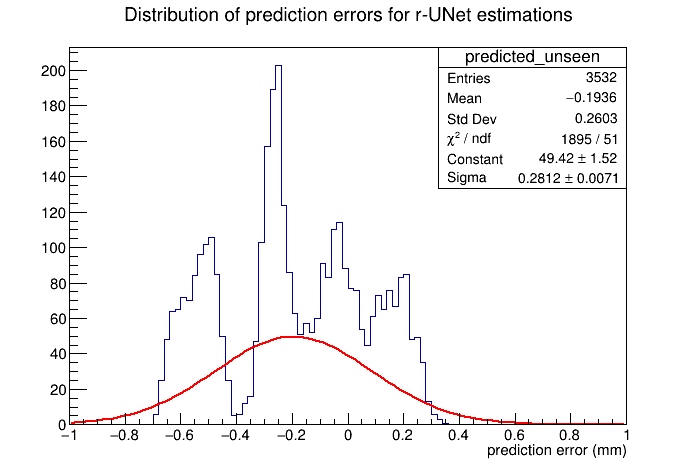

In [82]:
h, c, sigma, err = gaus_fit_avg(75, 100, 'predicted_unseen', '', n_bins=100)

Sigma: 0.17025 ± 0.00240


(<ROOT.TH1F object ("predicted_unseen") at 0x55c4b7f46b40>,
 <ROOT.TCanvas object ("c1_n12") at 0x55c4b7f25a60>,
 0.17025332210898636,
 0.0024016974828529186)

 FCN=632.466 FROM MIGRAD    STATUS=CONVERGED      53 CALLS          54 TOTAL
                     EDM=8.09169e-10    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     1.38381e+02   3.11789e+00   3.15829e-02   4.89617e-06
   2  Mean        -1.02848e-01     fixed    
   3  Sigma        1.70253e-01   2.40170e-03   4.83154e-05   9.82277e-03


Warning in <TROOT::Append>: Replacing existing TH1: predicted_unseen (Potential memory leak).
Info in <TCanvas::Print>: png file /storage/yw18581/src/leaf_reco/saved_models/trained_6positions/error_distributions/error_distribution_.png has been created


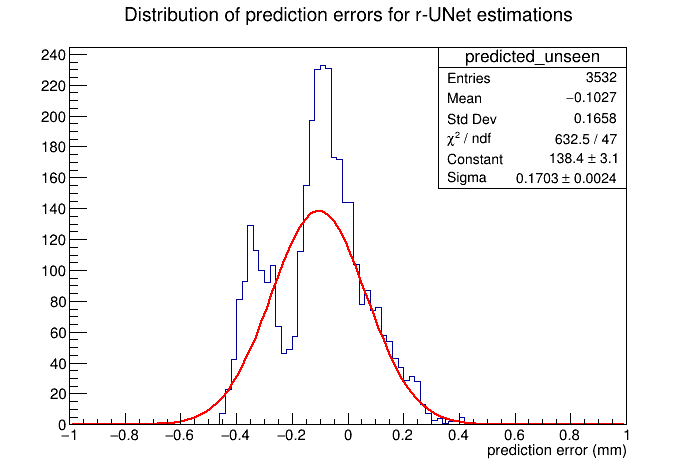

In [97]:
gaus_fit_avg(5, 55, 'predicted_unseen', '', n_bins=100)

Sigma: 0.08875 ± 0.00250


(<ROOT.TH1F object ("predicted_testdata") at 0x55c4b7f60ab0>,
 <ROOT.TCanvas object ("c1_n13") at 0x55c4b7f61040>,
 0.08874664095579418,
 0.0025017257012838606)

 FCN=142.277 FROM MIGRAD    STATUS=CONVERGED      43 CALLS          44 TOTAL
                     EDM=4.76616e-10    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     8.45695e+01   3.60689e+00   1.61415e-02  -1.10553e-05
   2  Mean         1.84056e-01     fixed    
   3  Sigma        8.87466e-02   2.50173e-03   4.06939e-05  -2.31586e-03


Info in <TCanvas::Print>: png file /storage/yw18581/src/leaf_reco/saved_models/trained_6positions/error_distributions/error_distribution_.png has been created


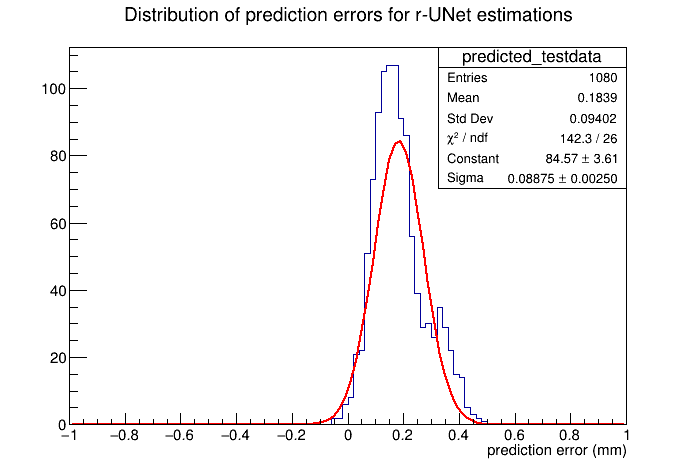

In [98]:
gaus_fit_avg(5, 55, 'predicted_testdata', '', n_bins=100)

In [99]:
def idx_mse(dist, true_arr, preds_arr):
    idx = np.where(true_arr==dist)[0]
    mse = mean_squared_error(true_arr[idx], preds_arr[idx])
    print(dist, mse)
    return idx, mse 

In [103]:
def gaus_fit_dist(coeff, epoch, fname_keyword, distances, out_file_key, save_file=False, 
                  n_bins = 10, histo_min = -1.0, histo_max = 1.0, print_sigma=True):
    filelist, epochs = get_fnames(coeff, prefix=fname_keyword)
    model = filelist[int(np.argwhere(epochs==epoch)[0])]

    data = np.load(root_path(model))
    
    true = data['true']
    preds = data['pred']
    sigmas = []
    errors = []
    for dist in distances:
        histo=None
        canvas=None
        idx = idx_mse(dist, preds_arr=preds, true_arr=true)[0]
        y_true = true[idx]
        y_pred = preds[idx]
        
        mean = np.mean(y_true-y_pred)
        histo = TH1F("{}_{}mm".format(fname_keyword, dist),
                 "Distribution of prediction errors for r-UNet estimations", 
                 n_bins,histo_min,histo_max)
        for i in (y_true-y_pred):
            histo.Fill(i)
    
        canvas = TCanvas()
        f = TF1("f","gaus")
        f.FixParameter(1,mean)

        histo.Fit(f, "S")
        histo.GetXaxis().SetTitle("prediction error (mm)");
        yax=histo.GetYaxis()
        yax.SetLimits(0,500)
        #histo.SetAxisRange(0, 500,"y")
        #gStyle.SetOptStat("nmR")
        gStyle.SetOptFit()
        gStyle.SetStatY(0.9)
        gStyle.SetStatX(0.9)
        gStyle.SetStatW(0.15)
        gStyle.SetStatH(0.15)
        histo.Draw()
        canvas.Draw()
        if save_file:
            print("saving as: {}".format(os.path.join(saved_models, 'error_distributions',
                                   '_'.join(["TEST_{}mm".format(dist),fkey])+".png")))
            canvas.SaveAs(os.path.join(saved_models, 'error_distributions',
                                   '_'.join(["TEST_{}mm".format(dist),fkey])+".png"))
        if print_sigma:
            sigma=f.GetParameter(2)
            err= f.GetParError(2)
            print('Sigma: {:.5f} ± {:.5f}'.format(sigma, err))
            sigmas.append(sigma)
            errors.append(err)
    return histo, canvas, sigmas, errors

In [101]:
test_distances = [2,4,10,20,25,35]

In [102]:
unseen_dist = [1,3,15,30]

1 0.27101602140377723
Sigma: 0.06178 ± 0.00136
3 0.01897365626255518
Sigma: 0.07295 ± 0.00227
15 0.13548099992701484
Sigma: 0.04302 ± 0.00106
30 0.13804626115639015
Sigma: 0.07104 ± 0.00195
 FCN=56.5124 FROM MIGRAD    STATUS=CONVERGED      35 CALLS          36 TOTAL
                     EDM=1.76704e-10    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     1.10270e+02   4.40103e+00   1.40596e-02   4.66816e-06
   2  Mean        -5.17044e-01     fixed    
   3  Sigma        6.17772e-02   1.35798e-03   2.34272e-05   2.27133e-03
 FCN=76.1022 FROM MIGRAD    STATUS=CONVERGED      46 CALLS          47 TOTAL
                     EDM=4.92499e-09    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant   

Warning in <TROOT::Append>: Replacing existing TH1: predicted_unseen_30mm (Potential memory leak).


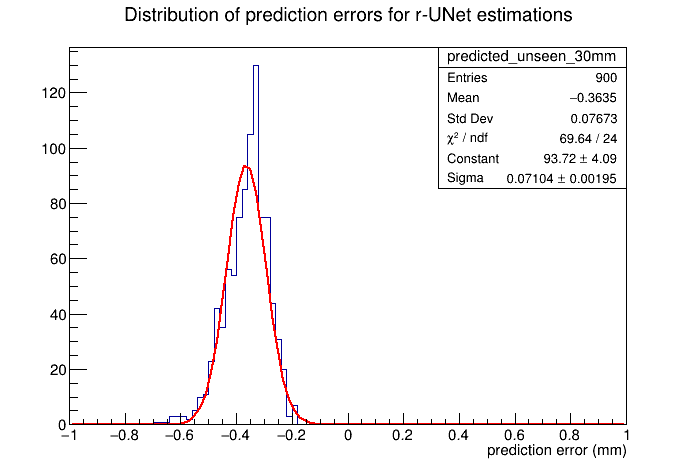

In [122]:
h, c, sigmas_unseen, errors_unseen = gaus_fit_dist(epoch=80, coeff=75, fname_keyword='predicted_unseen', distances=unseen_dist,
             out_file_key='', n_bins=100 )

2 0.018340652423307024
Sigma: 0.05277 ± 0.00361
4 0.023963183748769153
Sigma: 0.06425 ± 0.00462
10 0.020396492018963736
Sigma: 0.06236 ± 0.00461
20 0.029189986571549486
Sigma: 0.05157 ± 0.00383
25 0.04730410448561303
Sigma: 0.05039 ± 0.00321
35 0.11940526740493945
Sigma: 0.05001 ± 0.00350
 FCN=13.0203 FROM MIGRAD    STATUS=CONVERGED      40 CALLS          41 TOTAL
                     EDM=6.56635e-10    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     2.43688e+01   2.45260e+00   3.53383e-03   1.28199e-05
   2  Mean         1.25349e-01     fixed    
   3  Sigma        5.27686e-02   3.61207e-03   3.32590e-05  -3.07075e-04
 FCN=18.7805 FROM MIGRAD    STATUS=CONVERGED      36 CALLS          37 TOTAL
                     EDM=1.48759e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP       

Warning in <TROOT::Append>: Replacing existing TH1: predicted_testdata_35mm (Potential memory leak).


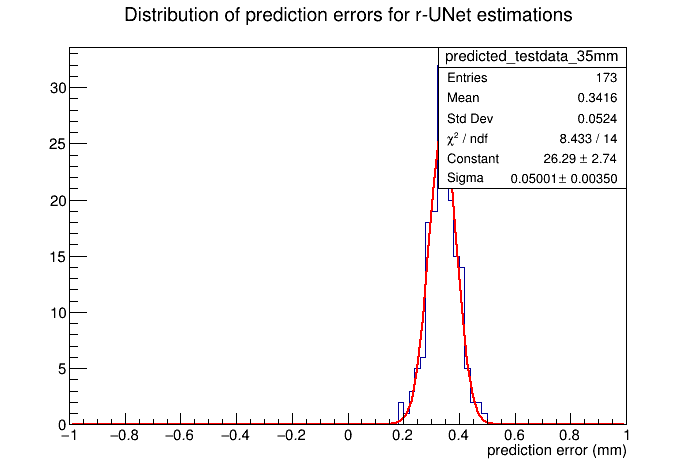

In [159]:
h, c, sigmas_test, errors_test= gaus_fit_dist(epoch=55, coeff=5, fname_keyword='predicted_testdata', distances=test_distances,
             out_file_key='', n_bins=100 )

In [160]:
sigmas_test

[0.05276864256582649,
 0.06425129395790229,
 0.062357942742514744,
 0.051574803252987224,
 0.05038513970688996,
 0.050009743448785685]

In [161]:
errors_test

[0.0036120669175944593,
 0.004618603819377658,
 0.004608647498381545,
 0.003834545350841538,
 0.0032111485674940904,
 0.003495336026758611]

In [162]:
sigmas_unseen

[0.061777229285342856,
 0.07294616818506733,
 0.043015637739066526,
 0.07103997269680182]

In [163]:
errors_unseen

[0.0013579810926186674,
 0.002270337929225409,
 0.001058241441340979,
 0.001947765820155066]

In [164]:
sigmas = sigmas_test+sigmas_unseen

In [165]:
errors = errors_test+errors_unseen

In [166]:
distances = test_distances+unseen_dist

In [167]:
import matplotlib.pyplot as plt

In [168]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

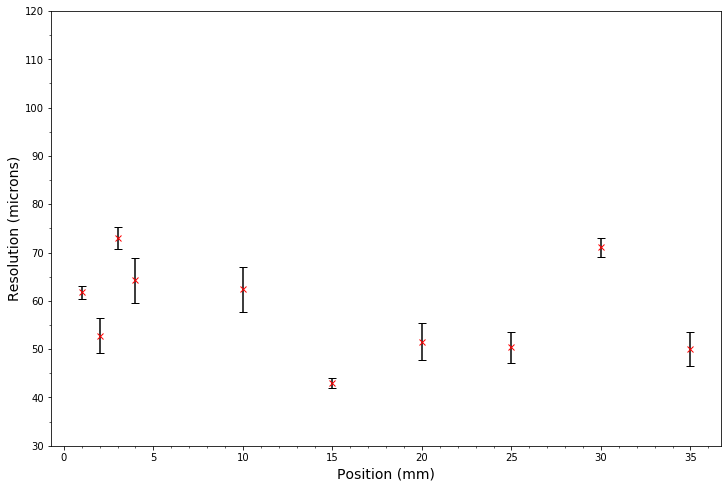

In [169]:
fig, ax = plt.subplots(figsize=(12,8))
ax.errorbar(np.sort(distances), np.array(sigmas)[np.argsort(distances)]*1000,
            np.array(errors)[np.argsort(distances)]*1000,
            fmt='x', capsize=4, c='red',ecolor='k')
ax.set_ylabel("Resolution (microns)", size=14)
ax.set_xlabel("Position (mm)", size=14)
ax.set_ylim(30,120)

ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(5))

In [152]:
distances = test_distances+unseen_dist

In [153]:
def mse_positions(coeff, epoch, fname_keyword, dist = unseen_dist):
    
    filelist, epochs = get_fnames(coeff, prefix=fname_keyword)
    model = filelist[int(np.argwhere(epochs==epoch)[0])]

    data = np.load(root_path(model))
    y_true = data['true']
    y_pred = data['pred']
    print(model)
    mse=[]
    avg=[]
    std=[]
    for d in dist:
        idx = idx_mse(d, preds_arr=y_pred, true_arr=y_true)[0]
        y_true_d = y_true[idx]
        y_pred_d = y_pred[idx]
        mse_d = mean_squared_error(y_true_d, y_pred_d)
        avg_pred = np.mean(y_pred_d)
        std_pred = np.std(y_pred_d)
        mse.append(mse_d)
        avg.append(avg_pred)
        std.append(std_pred)
    return mse, avg, std

In [154]:
mse_unseen, avg_unseen, std_unseen = mse_positions(5, 55, 'predicted_unseen')

predicted_unseen_6positions_55epochs_0.5coeff.npz
1 0.10725526988485204
3 0.021045900420130572
15 0.01412413165153541
30 0.00836011290245046


In [155]:
mse_test, avg_test, std_test = mse_positions(5, 55, 'predicted_testdata', dist=test_distances)

predicted_testdata_6positions_55epochs_0.5coeff.npz
2 0.018340652423307024
4 0.023963183748769153
10 0.020396492018963736
20 0.029189986571549486
25 0.04730410448561303
35 0.11940526740493945


In [156]:
std = mse_test+mse_unseen

In [157]:
avg = avg_test+avg_unseen

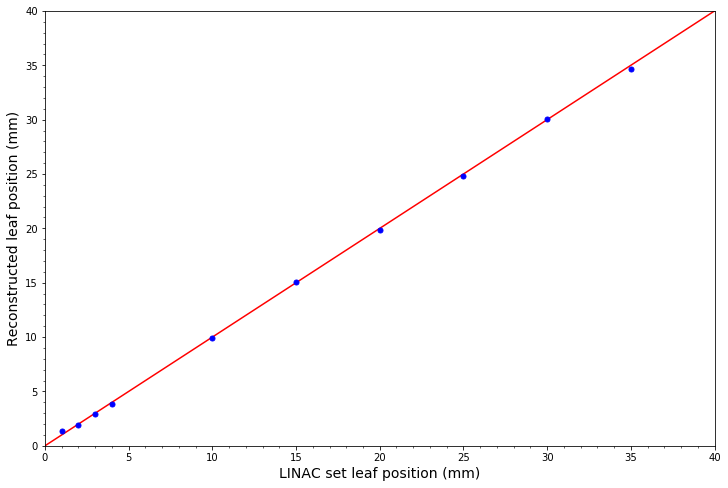

In [158]:
fig, ax = plt.subplots(figsize=(12,8))

ax.errorbar(np.sort(distances), np.array(avg)[np.argsort(distances)], 
                                np.array(std)[np.argsort(distances)], fmt='o',markersize=5, capsize=0, c='b',ecolor='b')
ax.plot(np.arange(0,50), np.arange(0,50),c='red')
#plt.xticks(np.arange(0,40,5))
#plt.yticks(np.arange(0,40,5))
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.xaxis.set_minor_locator(MultipleLocator(1))

ax.yaxis.set_minor_locator(MultipleLocator(1))
ax.set_ylabel("Reconstructed leaf position (mm)", size=14)
ax.set_xlabel("LINAC set leaf position (mm)", size=14)
ax.set_xlim(0,40)
ax.set_ylim(0,40)
plt.show()
#plt.savefig("reconstructed_vs_true_linear.png")

In [151]:
np.array(avg)[np.argsort(distances)]

array([ 1.5169474,  1.9900761,  2.9001012,  4.0159717, 10.055413 ,
       15.365527 , 20.09631  , 25.107346 , 30.363537 , 35.14626  ],
      dtype=float32)